<a href="https://colab.research.google.com/github/maritnorli/IFCB_CNN_Classify/blob/main/model_1_CNN_effnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Connect to cuda and Mount Drive manually in Colab!!!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Import the colab libraries and set up paths
from google.colab import drive
import os

## copy helper, train, etc scripts from drive to colab
import shutil
# Specify the path to your "going_modular" folder in Google Drive
drive_path = "/content/drive/MyDrive/IFCB/going_modular"


# List files in the "going_modular" folder
files = os.listdir(drive_path)

# Copy each file individually to the /content directory
for file in files:
    src = os.path.join(drive_path, file)
    dst = os.path.join("/content", file)
    try:
        shutil.copy(src, dst)
    except Exception as e:
        print(f"Failed to copy {file}: {e}")

# wait a minute or so before it pops up

In [ ]:
from pathlib import Path

# Set data paths
data_path = Path("/content/drive/MyDrive/IFCB/data/")
image_path = Path("/content/drive/MyDrive/IFCB/data/IFCB_test_train")

# Setup Dirs
train_dir = image_path / "Train"
test_dir = image_path / "Test"


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Now try importing modules directly from the copied drive files
try:
    import data_setup
    import engine

except ModuleNotFoundError as e:
    print(f"Failed to import modules: {e}")


[INFO] Couldn't find torchinfo... installing it.


In [ ]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Create transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((244, 244)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [ ]:
# Create training and testing dataloaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7eadf943bb80>,
 ['Akashiwo_sanguinea_057',
  'Amphidinium_like_015',
  'Apedinella_radians_031',
  'Asterionellopsis_glacialis_034'])

In [ ]:
# Make a model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

#freeze base layers
for param in model_1.features.parameters():
  param.requires_grad = False

#Change classification head
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2),
    #Here: we want to keep the tensor size of infeatures in efficientnet as 1280,
    #but change the length of out features from 1000 to 3 (class outputs)
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)
model_1

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
#Create a loss and optimizer
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0871 | train_acc: 0.7375 | test_loss: 1.2772 | test_acc: 0.4271
Epoch: 2 | train_loss: 0.6945 | train_acc: 0.9005 | test_loss: 1.2680 | test_acc: 0.4427
Epoch: 3 | train_loss: 0.4462 | train_acc: 0.9625 | test_loss: 1.2035 | test_acc: 0.6094
Epoch: 4 | train_loss: 0.3560 | train_acc: 0.9505 | test_loss: 1.0934 | test_acc: 0.5260
Epoch: 5 | train_loss: 0.2340 | train_acc: 0.9875 | test_loss: 0.9330 | test_acc: 0.6250
Epoch: 6 | train_loss: 0.1639 | train_acc: 0.9938 | test_loss: 0.7751 | test_acc: 0.7188
Epoch: 7 | train_loss: 0.1519 | train_acc: 0.9938 | test_loss: 0.5904 | test_acc: 0.9062
Epoch: 8 | train_loss: 0.1773 | train_acc: 0.9721 | test_loss: 0.4256 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.1073 | train_acc: 0.9846 | test_loss: 0.3025 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.0868 | train_acc: 0.9938 | test_loss: 0.2250 | test_acc: 1.0000
[INFO] Total training time: 65.152 seconds


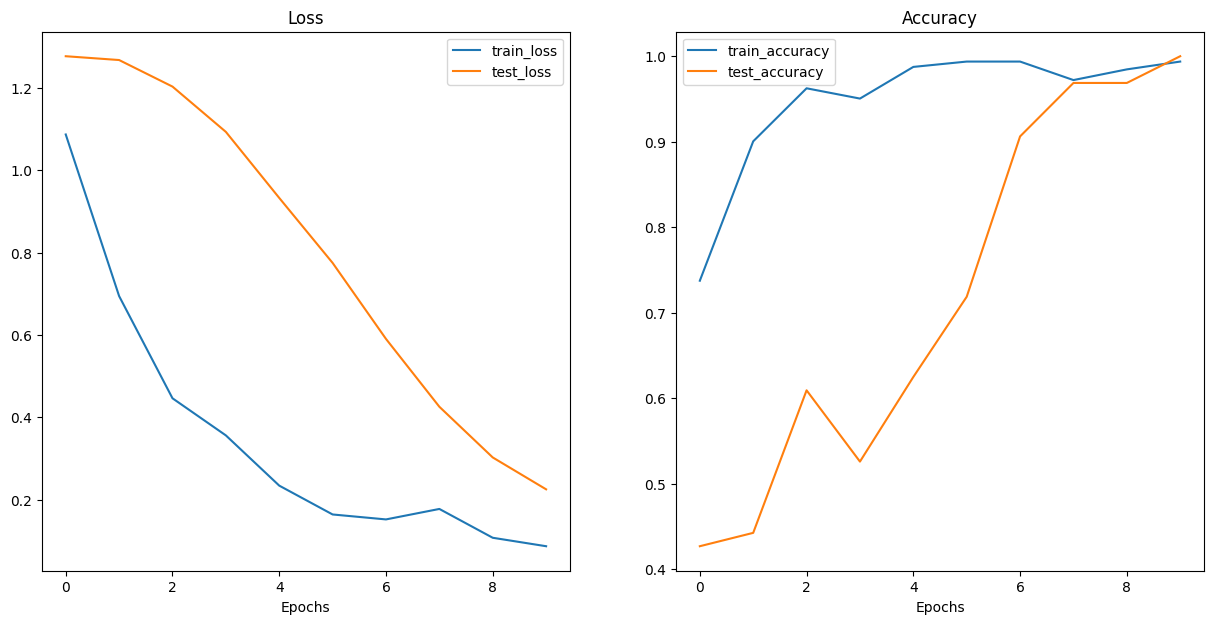

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves
#Plot the loss urves of model_1
plot_loss_curves(model_1_results)